# Usage

This Jupyter Notebook presents usage examples for features of `epymorph`.

The most basic task epymorph can perform is to run a spatial, compartmental disease simulation and output the time-series data of compartment populations (prevalence) as well as events ocurrences (incidence).

A commonly-cited model was proposed by [Sen Pei, et al. in 2018](https://www.pnas.org/doi/10.1073/pnas.1708856115), modeling influenza in six 
southern US states. epymorph has an intra-population model (**IPM**), movement model (**MM**), and geographic model that mimics Pei's experiment. (But keep in mind that it's possible to mix and match different models!)

Start by constructing a runnable modeling experiment (**RUME**) by combining an IPM and MM. These modules are registered in our library, so it's straightforward to import them from there.

Then specify an **Initializer** to set up initial conditions. This determines how the initial disease model compartments are set up: the starting populations of each. There is a library of included initialization routines in the initializer module, or you can write your own. In this example we use the `SingleLocation` initializer to seed an infection in one location.

Also include the required geographic and parameters data. Which parameters do you need to provide? IPMs, MMs, and Initializers each define the data attributes that they need. So the exact set varies between RUMEs. For now, suffice to say there are ways to inspect the objects to find out what those requirements are. There's no harm in providing extra, unused parameters, but if you are missing any you'll get an error.

In [1]:
from epymorph.kit import *
from epymorph.adrio import acs5, commuting_flows, us_tiger
from epymorph.data.pei import pei_humidity


rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.Pei(),
    # Load the Pei MM
    mm=mm.Pei(),
    # Describe the geographic scope of our simulation:
    scope=StateScope.in_states(["FL", "GA", "MD", "NC", "SC", "VA"], year=2015),
    # Create a SingleLocation initializer
    init=init.SingleLocation(location=0, seed_size=10_000),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2015-01-01", 150),
    # Provide model parameter values
    params={
        "theta": 0.1,
        "move_control": 0.9,
        "infection_duration": 4,
        "immunity_duration": 90,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population(),
        "commuters": commuting_flows.Commuters(),
        # Except this one...
        # We don't have a humidity ADRIO yet, so we need to load it another way.
        # For now, we have the Pei data files in the project as a convenience.
        "humidity": pei_humidity,
    },
)

Before moving on, let's see the IPM as a transition diagram. epymorph has a built-in function to do this.

You'll see a fairly standard SIRS model where the infection parameter ($\beta$) has been modeled as a function of humidity. In this simulation, the value of humidity varies between locations and over time, as you would expect!

> *Technical note*: running this cell requires you to have some additional software installed -- graphviz and a LaTeX distribution, both of which should be supported on Windows, Mac, and Linux. You will get an error here if they're missing. Installation instructions for [graphviz](https://graphviz.org/download/) can be found at its website, and there are several LaTeX distributions to choose from; we recommend either [TeX Live](https://tug.org/texlive/) or [MiKTeX](https://miktex.org/download).

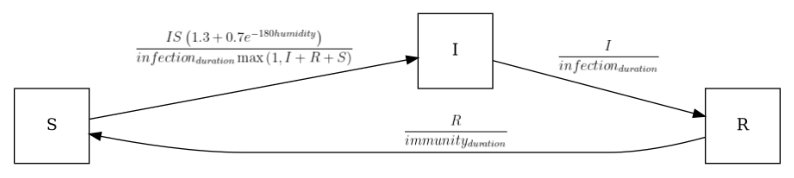

In [2]:
rume.ipm.diagram()

Now that you have a RUME, choose what kind of simulation you'd like to run by constructing a Simulator class. In thi case, run a single realization and view its output -- the `BasicSimulator` is ideal for this.

Then call the `run` method to simulate the model and produce an `Output` object. (Note that it's perfectly legal to call `run` repeatedly. If you don't specify a seeded RNG, you would see slightly different results each time due to stochastic variations.)

In [3]:
# Construct a simulator for the RUME
sim = BasicSimulator(rume)

# Run inside a sim_messaging context to display a nice progress bar
with sim_messaging():
    # Run and save the simulation Output object for later
    out = sim.run(
        # Use a seeded RNG (for the sake of keeping this notebook's results consistent)
        # This parameter is optional; by default a new RNG is constructed for each run
        # using numpy's default_rng
        rng_factory=default_rng(1)
    )

Loading gpm:all::mm::commuters (epymorph.adrio.commuting_flows.Commuters):
  |####################| 100%  (9.760s)
Loading gpm:all::init::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.866s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-30 (150 days)
• 6 geo nodes
  |####################| 100%                     
Runtime: 0.164s


The `Output` object contains time-series compartment and event data for each population in our geo scope, as well as some metadata about the simulation that produced the output. Now we can inspect the results!

In [4]:
print(f"Compartments is an array of shape: {out.compartments.shape}")
print(
    "That's (S,N,C) -- simulation time steps, number of geo nodes, "
    "and number of IPM compartments."
)

print()

print(f"Events is an array of shape: {out.events.shape}")
print(
    "That's (S,N,E) -- simulation time steps, number of geo nodes, "
    "and number of IPM events."
)

print()

print("Here are the initial conditions (SIR) for all six geo nodes:")
print(out.initial[:, :])

print()

print(
    "And here are the SIR compartment values for the first geo node (Florida) "
    "after the first ten timesteps:"
)
print(out.compartments[0:10, 0, :])

Compartments is an array of shape: (300, 6, 3)
That's (S,N,C) -- simulation time steps, number of geo nodes, and number of IPM compartments.

Events is an array of shape: (300, 6, 3)
That's (S,N,E) -- simulation time steps, number of geo nodes, and number of IPM events.

Here are the initial conditions (SIR) for all six geo nodes:
[[19635772    10000        0]
 [10006693        0        0]
 [ 5930538        0        0]
 [ 9845333        0        0]
 [ 4777576        0        0]
 [ 8256630        0        0]]

And here are the SIR compartment values for the first geo node (Florida) after the first ten timesteps:
[[19632641    10319      844]
 [19632158    11119     2495]
 [19628627    11471     3400]
 [19628158    12340     5274]
 [19624669    12716     6312]
 [19623707    13669     8396]
 [19619738    14127     9457]
 [19618845    15151    11776]
 [19615205    15659    12982]
 [19613501    16746    15525]]


The prevalence data is a 3-dimensional numpy array of integers of shape `(S,N,C)`, where `S` is the number of time steps in the simulation, `N` is the number of geo nodes, and `C` is the number of compartments in the IPM.

The incidence data is similar, but of shape `(S,N,E)`, where `E` is the number of transition events (directed edges from one IPM compartment to another, associated with some sort of transition rate).

You may notice that our time frame says to run the simulation for 150 days. So where did 300 ticks come from? Without diving too deep, epymorph breaks up each day into parts called *tau steps* (1 or more) and runs its computations one tau step at a time. The movement model is what dictates how many tau steps there are in a day and how long each one is. In this example, there are 2 tau steps, and so $(150 \times 2)$ simulation ticks.

You can also do more interesting things, like plot the data over time. There is a small built-in plotting library in epymorph (which uses matplotlib behind the scenes).

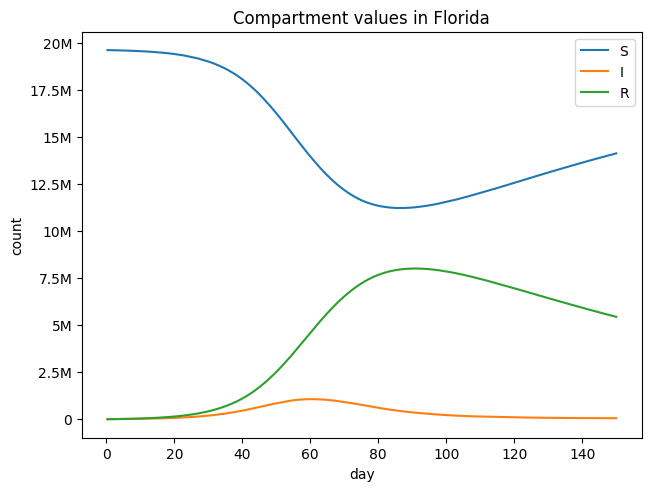

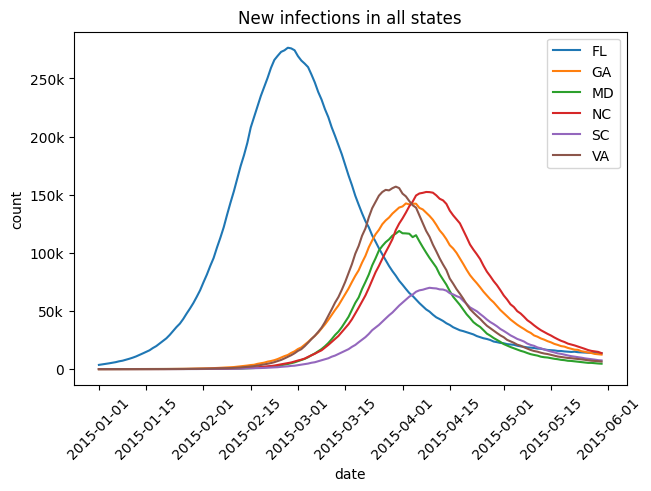

In [5]:
# Plot the compartment values in Florida throughout the simulation.
out.plot.line(
    geo=rume.scope.select.by_state("Florida"),
    time=rume.time_frame.select.all(),
    quantity=rume.ipm.select.compartments(),
    title="Compartment values in Florida",
    label_format="{q}",
)

# Plot new occurrences for the S->I event for all places.
# Because the number of events that occur in any time step
# is sensitive to the length of that time step, and especially
# because the tau steps for this simulation are of varying length,
# we will group and sum by day to smooth out the inter-day variation.
out.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.events("S->I"),
    title="New infections in all states",
    label_format="{n}",
)

The output also keeps a reference to the RUME that created it, so you can use that to recover contextual information. For example, how many nodes there were, their labels, and labels for the compartment model.

In [6]:
print(f"There were {out.rume.scope.nodes} nodes!")
print(f"Whose labels are: {out.rume.scope.labels}")

print()

print(f"IPM compartments: {[str(c.name) for c in out.rume.ipm.compartments]}")
print(f"IPM events: {[str(e.name) for e in out.rume.ipm.events]}")

There were 6 nodes!
Whose labels are: ['FL' 'GA' 'MD' 'NC' 'SC' 'VA']

IPM compartments: ['S', 'I', 'R']
IPM events: ['S → I', 'I → R', 'R → S']
